In [5]:
import sys
import os
import pandas as pd
import networkx as nx


# add parent directory to path so we can import from util
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# import module from util
from util.nc_backbone import nc_backbone
from util.project import project
from util.get_edge_list import get_edge_list
from util.merge_fams import merge_fams

df = merge_fams('../data/CosciaRios2012_DataBase.csv')
min_year = df['Year'].min()
max_year = df['Year'].max()
families = df.columns[3:]

alpha_value = 0.4
G_backboned = {}
G_original = {}
edges_evol = {'year': [], 'bb_edges': [], 'og_edges': []}

for year in range(min_year, max_year + 1):
    df_year = df[df['Year'] == year]
    adj = project(df_year, on_municipalities=False)
    edge_list = get_edge_list(adj)

    G_original[year] = nx.Graph()
    G_original[year].add_nodes_from(families)
    G_original[year].add_weighted_edges_from(edge_list)

    bb_edge_list = nc_backbone(adj, alpha=alpha_value)

    G_backboned[year] = nx.Graph()
    G_backboned[year].add_nodes_from(families)
    G_backboned[year].add_weighted_edges_from(bb_edge_list)

    edges_evol['year'].append(year)
    edges_evol['bb_edges'].append(nx.density(G_backboned[year]))
    edges_evol['og_edges'].append(nx.density(G_original[year]))
    
df_edges_evol = pd.DataFrame(edges_evol)
df_edges_evol

,year,bb_edges,og_edges
0,1990,0.000000,0.000000
1,1991,0.000000,0.000000
2,1992,0.000000,0.035714
3,1993,0.071429,0.071429
4,1994,0.000000,0.071429
5,1995,0.035714,0.071429
6,1996,0.071429,0.142857
7,1997,0.035714,0.035714
8,1998,0.107143,0.142857
9,1999,0.071429,0.071429


In [6]:
import networkx as nx
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

def smallest_signed_laplacian_eigenpair(G):
    """
    Computes the smallest eigenvalue and eigenvector of the signed Laplacian
    assuming ALL edges are negative.

    Parameters
    ----------
    G : networkx.Graph
        Undirected graph (unsigned)

    Returns
    -------
    lambda_min : float
        Smallest eigenvalue
    v_min : np.ndarray
        Corresponding eigenvector (ordered by G.nodes())
    """

    # Fix node ordering
    nodes = list(G.nodes())
    idx = {node: i for i, node in enumerate(nodes)}
    n = len(nodes)

    # Build signed adjacency matrix (all edges = -1)
    rows, cols, data = [], [], []

    for u, v in G.edges():
        i, j = idx[u], idx[v]
        rows.extend([i, j])
        cols.extend([j, i])
        data.extend([-1.0, -1.0])

    A = sp.csr_matrix((data, (rows, cols)), shape=(n, n))

    # Degree matrix (absolute degrees)
    degrees = np.array(np.abs(A).sum(axis=1)).flatten()
    D = sp.diags(degrees)

    # Signed Laplacian
    L = D - A

    # Smallest eigenvalue/vector
    lambda_min, v_min = spla.eigsh(L, k=1, which='SM')

    return lambda_min[0], v_min[:, 0]


In [7]:

lambda_min, eigenvector = smallest_signed_laplacian_eigenpair(G_backboned[2010])

print("Smallest eigenvalue:", lambda_min)


Smallest eigenvalue: 1.0000000000000004


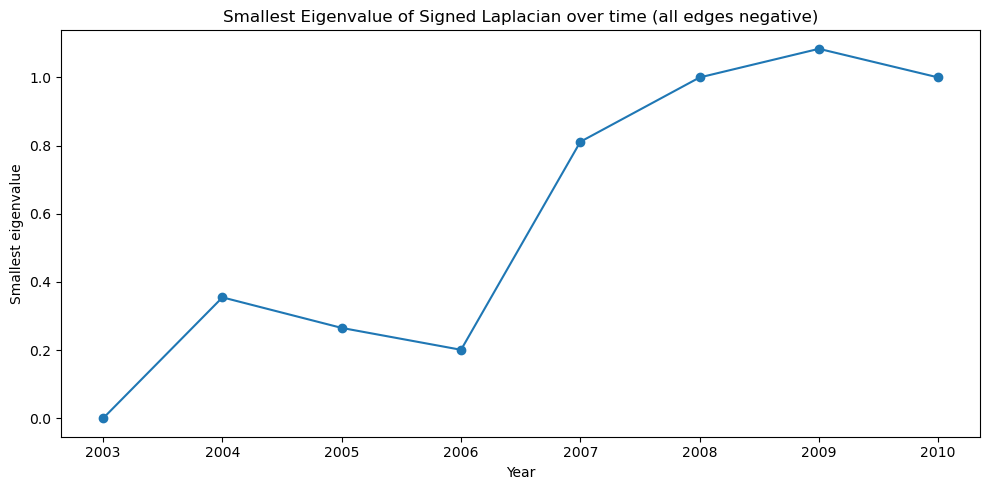

2003 1.5340917079055395e-92
2004 0.3547223260255083
2005 0.2650299263728507
2006 0.20084390155734658
2007 0.811243456591479
2008 0.9999999999999996
2009 1.0840213816645345
2010 0.9999999999999998


In [8]:
import numpy as np
import matplotlib.pyplot as plt

years = range(2003, 2011)

lambda_by_year = {}
lambdas = []

for y in years:
    # If dict key missing, skip safely
    if y not in G_backboned:
        lambda_by_year[y] = np.nan
        lambdas.append(np.nan)
        continue

    G = G_backboned[y]

    # If graph has no edges (or no nodes), eigensolver would fail → store NaN
    if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
        lambda_by_year[y] = np.nan
        lambdas.append(np.nan)
        continue

    # Compute smallest eigenvalue
    lam, _ = smallest_signed_laplacian_eigenpair(G)

    # Clamp tiny negative numerical noise to 0
    if lam < 0 and abs(lam) < 1e-10:
        lam = 0.0

    lambda_by_year[y] = float(lam)
    lambdas.append(float(lam))

# Plot (matplotlib will break the line where NaNs exist, which is what you want)
plt.figure(figsize=(10, 5))
plt.plot(list(years), lambdas, marker="o")
plt.xlabel("Year")
plt.ylabel("Smallest eigenvalue")
plt.title("Smallest Eigenvalue of Signed Laplacian over time (all edges negative)")
plt.xticks(list(years))
plt.grid(False)
plt.tight_layout()
plt.show()


# Optional: print values
for y in years:
    print(y, lambda_by_year[y])


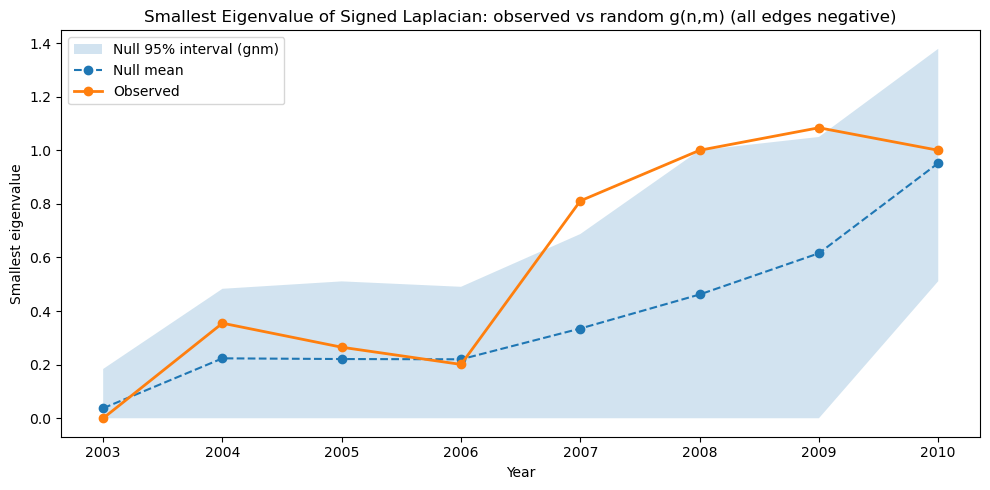

2003 obs= 4.534201467086688e-94 null_mean= 0.0374482411162903 null_lo= 0.0 null_hi= 0.1838448745012286
2004 obs= 0.3547223260255087 null_mean= 0.22358150060881107 null_lo= 5.552994188085593e-94 null_hi= 0.48313189157481196
2005 obs= 0.2650299263728512 null_mean= 0.22097094266742348 null_lo= 1.1603094726377e-94 null_hi= 0.5107515768212575
2006 obs= 0.2008439015573459 null_mean= 0.21999433340421184 null_lo= 0.0 null_hi= 0.49055601749815114
2007 obs= 0.8112434565914786 null_mean= 0.3348778387650082 null_lo= 1.9059408758352605e-93 null_hi= 0.6874334872348185
2008 obs= 0.9999999999999998 null_mean= 0.46185981751897887 null_lo= 3.801723842217288e-93 null_hi= 1.0
2009 obs= 1.0840213816645343 null_mean= 0.6157426745562171 null_lo= 1.1313926345803358e-92 null_hi= 1.0496944377544206
2010 obs= 1.0 null_mean= 0.952070178293862 null_lo= 0.5114220509860122 null_hi= 1.3786412375145198


In [26]:
import networkx as nx
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

def smallest_signed_laplacian_eigenpair(G):
    """
    Smallest eigenvalue/eigenvector of signed Laplacian assuming ALL edges are negative.
    """
    nodes = list(G.nodes())
    n = len(nodes)
    if n < 2 or G.number_of_edges() == 0:
        return np.nan, None

    idx = {node: i for i, node in enumerate(nodes)}

    rows, cols, data = [], [], []
    for u, v in G.edges():
        i, j = idx[u], idx[v]
        rows.extend([i, j])
        cols.extend([j, i])
        data.extend([-1.0, -1.0])

    A = sp.csr_matrix((data, (rows, cols)), shape=(n, n))
    degrees = np.array(np.abs(A).sum(axis=1)).flatten()
    D = sp.diags(degrees)
    L = D - A

    # eigsh requires k < n; we already guarded n<2 above
    try:
        lam, vec = spla.eigsh(L, k=1, which='SM')
        lam = float(lam[0])
        if lam < 0 and abs(lam) < 1e-10:  # clamp tiny numerical noise
            lam = 0.0
        return lam, vec[:, 0]
    except Exception:
        return np.nan, None


# --- Null model generators ---

def generate_null_graph(G, model="gnm", rng=None):
    """
    Generate a random graph "similar" to G.
    model:
      - "gnm": Erdos-Renyi G(n, m) (same nodes, same number of edges)
      - "config": configuration model (approximately preserves degree sequence)
    """
    if rng is None:
        rng = np.random.default_rng()

    nodes = list(G.nodes())
    n = len(nodes)
    m = G.number_of_edges()

    if n < 2 or m == 0:
        return None

    if model == "gnm":
        H = nx.gnm_random_graph(n=n, m=m, seed=int(rng.integers(0, 2**32 - 1)))
        # relabel to original nodes for consistency (optional)
        mapping = {i: nodes[i] for i in range(n)}
        return nx.relabel_nodes(H, mapping)

    elif model == "config":
        deg_seq = [G.degree(u) for u in nodes]
        # configuration_model returns a MultiGraph with possible self-loops / multi-edges
        MG = nx.configuration_model(deg_seq, seed=int(rng.integers(0, 2**32 - 1)))
        # convert to simple graph
        H = nx.Graph(MG)
        H.remove_edges_from(nx.selfloop_edges(H))
        # relabel to original nodes
        mapping = {i: nodes[i] for i in range(n)}
        H = nx.relabel_nodes(H, mapping)
        return H

    else:
        raise ValueError("model must be 'gnm' or 'config'")


def summarize_interval(samples, alpha=0.05, kind="percentile"):
    """
    Return mean and interval.
    kind:
      - "percentile": [alpha/2, 1-alpha/2] percentiles of the sample distribution
      - "mean_ci":  t-approx CI for the mean (normal approx); good if sims large
    """
    x = np.asarray(samples, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return np.nan, np.nan, np.nan

    mean = float(np.mean(x))

    if kind == "percentile":
        lo = float(np.quantile(x, alpha/2))
        hi = float(np.quantile(x, 1 - alpha/2))
        return mean, lo, hi

    elif kind == "mean_ci":
        # Normal approximation CI for mean
        se = float(np.std(x, ddof=1) / np.sqrt(len(x))) if len(x) > 1 else np.nan
        z = 1.96  # ~95%
        lo = mean - z * se if np.isfinite(se) else np.nan
        hi = mean + z * se if np.isfinite(se) else np.nan
        return mean, lo, hi

    else:
        raise ValueError("kind must be 'percentile' or 'mean_ci'")


# --- Your yearly loop + ensemble ---

years = range(2003, 2011)

n_sims = 200                 # <- increase for smoother bands
null_model = "gnm"           # "gnm" (same n,m) or "config" (degree-seq)
interval_kind = "percentile" # "percentile" (distribution band) or "mean_ci" (CI of mean)
alpha = 0.05                 # 95% interval

lambda_obs = []
null_mean = []
null_lo = []
null_hi = []

rng = np.random.default_rng(42)

for y in years:
    if y not in G_backboned:
        lambda_obs.append(np.nan)
        null_mean.append(np.nan); null_lo.append(np.nan); null_hi.append(np.nan)
        continue

    G = G_backboned[y]
    if G.number_of_nodes() < 2 or G.number_of_edges() == 0:
        lambda_obs.append(np.nan)
        null_mean.append(np.nan); null_lo.append(np.nan); null_hi.append(np.nan)
        continue

    # Observed
    lam_obs, _ = smallest_signed_laplacian_eigenpair(G)
    lambda_obs.append(lam_obs)

    # Null ensemble
    sims = []
    for _ in range(n_sims):
        H = generate_null_graph(G, model=null_model, rng=rng)
        if H is None or H.number_of_nodes() < 2 or H.number_of_edges() == 0:
            sims.append(np.nan)
            continue
        lam_h, _ = smallest_signed_laplacian_eigenpair(H)
        sims.append(lam_h)

    m, lo, hi = summarize_interval(sims, alpha=alpha, kind=interval_kind)
    null_mean.append(m); null_lo.append(lo); null_hi.append(hi)


# --- Plot everything on one figure ---

plt.figure(figsize=(10, 5))

# Null band + mean
plt.fill_between(list(years), null_lo, null_hi, alpha=0.2, label=f"Null {int((1-alpha)*100)}% interval ({null_model})")
plt.plot(list(years), null_mean, marker="o", linestyle="--", label="Null mean")

# Observed line
plt.plot(list(years), lambda_obs, marker="o", linewidth=2, label="Observed")

plt.xlabel("Year")
plt.ylabel("Smallest eigenvalue")
plt.title("Smallest Eigenvalue of Signed Laplacian: observed vs random g(n,m) (all edges negative)")
plt.xticks(list(years))
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.show()

# Optional: print table
for i, y in enumerate(years):
    print(y, "obs=", lambda_obs[i], "null_mean=", null_mean[i], "null_lo=", null_lo[i], "null_hi=", null_hi[i])


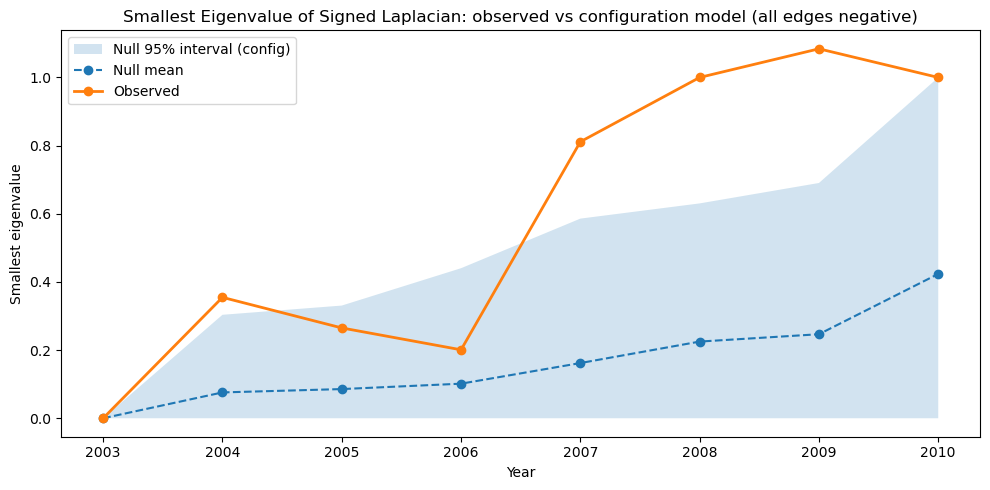

2003 obs= 1.245420869116447e-78 null_mean= 1.2697571836403104e-50 null_lo= 0.0 null_hi= 1.2042340439214332e-49
2004 obs= 0.3547223260255085 null_mean= 0.0757841961447913 null_lo= 0.0 null_hi= 0.3035741002925187
2005 obs= 0.26502992637285167 null_mean= 0.08560874742665538 null_lo= 0.0 null_hi= 0.3306192200442075
2006 obs= 0.20084390155734638 null_mean= 0.10143377816595642 null_lo= 0.0 null_hi= 0.44025379321613894
2007 obs= 0.8112434565914789 null_mean= 0.1619620906263929 null_lo= 0.0 null_hi= 0.5857864376269045
2008 obs= 0.9999999999999999 null_mean= 0.2249645717743637 null_lo= 0.0 null_hi= 0.6303884538088463
2009 obs= 1.0840213816645337 null_mean= 0.24654692009797338 null_lo= 0.0 null_hi= 0.6902994604217302
2010 obs= 1.0000000000000007 null_mean= 0.4234713048002424 null_lo= 0.0 null_hi= 1.0000000000000002


In [27]:
import networkx as nx
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

def smallest_signed_laplacian_eigenpair(G):
    """
    Smallest eigenvalue/eigenvector of signed Laplacian assuming ALL edges are negative.
    """
    nodes = list(G.nodes())
    n = len(nodes)
    if n < 2 or G.number_of_edges() == 0:
        return np.nan, None

    idx = {node: i for i, node in enumerate(nodes)}

    rows, cols, data = [], [], []
    for u, v in G.edges():
        i, j = idx[u], idx[v]
        rows.extend([i, j])
        cols.extend([j, i])
        data.extend([-1.0, -1.0])

    A = sp.csr_matrix((data, (rows, cols)), shape=(n, n))
    degrees = np.array(np.abs(A).sum(axis=1)).flatten()
    D = sp.diags(degrees)
    L = D - A

    # eigsh requires k < n; we already guarded n<2 above
    try:
        lam, vec = spla.eigsh(L, k=1, which='SM')
        lam = float(lam[0])
        if lam < 0 and abs(lam) < 1e-10:  # clamp tiny numerical noise
            lam = 0.0
        return lam, vec[:, 0]
    except Exception:
        return np.nan, None


# --- Null model generators ---

def generate_null_graph(G, model="config", rng=None):
    """
    Generate a random graph "similar" to G.
    model:
      - "config": configuration model (approximately preserves degree sequence)
    """
    if rng is None:
        rng = np.random.default_rng()

    nodes = list(G.nodes())
    n = len(nodes)
    m = G.number_of_edges()

    if n < 2 or m == 0:
        return None

    if model == "config":
        deg_seq = [G.degree(u) for u in nodes]
        # configuration_model returns a MultiGraph with possible self-loops / multi-edges
        MG = nx.configuration_model(deg_seq, seed=int(rng.integers(0, 2**32 - 1)))
        # convert to simple graph
        H = nx.Graph(MG)
        H.remove_edges_from(nx.selfloop_edges(H))
        # relabel to original nodes
        mapping = {i: nodes[i] for i in range(n)}
        H = nx.relabel_nodes(H, mapping)
        return H

    else:
        raise ValueError("model must be 'config'")


def summarize_interval(samples, alpha=0.05, kind="percentile"):
    """
    Return mean and interval.
    kind:
      - "percentile": [alpha/2, 1-alpha/2] percentiles of the sample distribution
      - "mean_ci":  t-approx CI for the mean (normal approx); good if sims large
    """
    x = np.asarray(samples, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return np.nan, np.nan, np.nan

    mean = float(np.mean(x))

    if kind == "percentile":
        lo = float(np.quantile(x, alpha/2))
        hi = float(np.quantile(x, 1 - alpha/2))
        return mean, lo, hi

    elif kind == "mean_ci":
        # Normal approximation CI for mean
        se = float(np.std(x, ddof=1) / np.sqrt(len(x))) if len(x) > 1 else np.nan
        z = 1.96  # ~95%
        lo = mean - z * se if np.isfinite(se) else np.nan
        hi = mean + z * se if np.isfinite(se) else np.nan
        return mean, lo, hi

    else:
        raise ValueError("kind must be 'percentile' or 'mean_ci'")


# --- Your yearly loop + ensemble ---

years = range(2003, 2011)

n_sims = 200                 # <- increase for smoother bands
null_model = "config"        # configuration model (degree-seq)
interval_kind = "percentile" # "percentile" (distribution band) or "mean_ci" (CI of mean)
alpha = 0.05                 # 95% interval

lambda_obs = []
null_mean = []
null_lo = []
null_hi = []

rng = np.random.default_rng(42)

for y in years:
    if y not in G_backboned:
        lambda_obs.append(np.nan)
        null_mean.append(np.nan); null_lo.append(np.nan); null_hi.append(np.nan)
        continue

    G = G_backboned[y]
    if G.number_of_nodes() < 2 or G.number_of_edges() == 0:
        lambda_obs.append(np.nan)
        null_mean.append(np.nan); null_lo.append(np.nan); null_hi.append(np.nan)
        continue

    # Observed
    lam_obs, _ = smallest_signed_laplacian_eigenpair(G)
    lambda_obs.append(lam_obs)

    # Null ensemble (configuration model)
    sims = []
    for _ in range(n_sims):
        H = generate_null_graph(G, model=null_model, rng=rng)
        if H is None or H.number_of_nodes() < 2 or H.number_of_edges() == 0:
            sims.append(np.nan)
            continue
        lam_h, _ = smallest_signed_laplacian_eigenpair(H)
        sims.append(lam_h)

    m, lo, hi = summarize_interval(sims, alpha=alpha, kind=interval_kind)
    null_mean.append(m); null_lo.append(lo); null_hi.append(hi)


# --- Plot everything on one figure ---

plt.figure(figsize=(10, 5))

# Null band + mean
plt.fill_between(list(years), null_lo, null_hi, alpha=0.2,
                 label=f"Null {int((1-alpha)*100)}% interval ({null_model})")
plt.plot(list(years), null_mean, marker="o", linestyle="--", label="Null mean")

# Observed line
plt.plot(list(years), lambda_obs, marker="o", linewidth=2, label="Observed")

plt.xlabel("Year")
plt.ylabel("Smallest eigenvalue")
plt.title("Smallest Eigenvalue of Signed Laplacian: observed vs configuration model (all edges negative)")
plt.xticks(list(years))
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.show()

# Optional: print table
for i, y in enumerate(years):
    print(y, "obs=", lambda_obs[i], "null_mean=", null_mean[i], "null_lo=", null_lo[i], "null_hi=", null_hi[i])


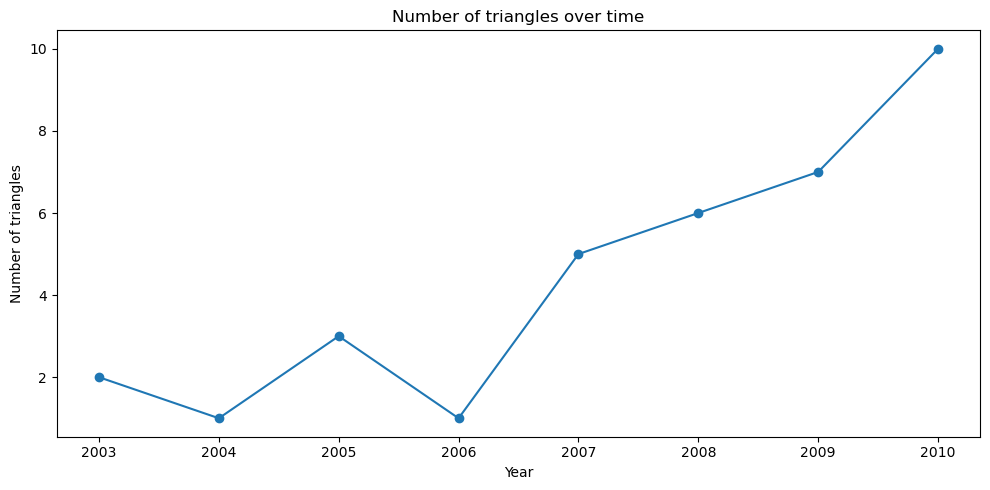

2003 2
2004 1
2005 3
2006 1
2007 5
2008 6
2009 7
2010 10


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

years = range(2003, 2011)

triangles_by_year = {}
triangles = []

for y in years:
    # If dict key missing, skip safely
    if y not in G_backboned:
        triangles_by_year[y] = np.nan
        triangles.append(np.nan)
        continue

    G = G_backboned[y]

    # If graph has no edges or too few nodes, no triangles possible
    if G.number_of_nodes() < 3 or G.number_of_edges() == 0:
        triangles_by_year[y] = 0
        triangles.append(0)
        continue

    # Count triangles
    tri_dict = nx.triangles(G)
    n_triangles = sum(tri_dict.values()) // 3  # each triangle counted 3 times

    triangles_by_year[y] = n_triangles
    triangles.append(n_triangles)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(list(years), triangles, marker="o")
plt.xlabel("Year")
plt.ylabel("Number of triangles")
plt.title("Number of triangles over time")
plt.xticks(list(years))
plt.grid(False)
plt.tight_layout()
plt.show()

# Optional: print values
for y in years:
    print(y, triangles_by_year[y])


In [18]:
G_backboned[2010]

G_backboned[2010].nodes


NodeView(('Beltran_Leyva', 'Familia', 'Golfo', 'Juarez', 'Sinaloa', 'Tijuana', 'Zetas', 'Otros'))

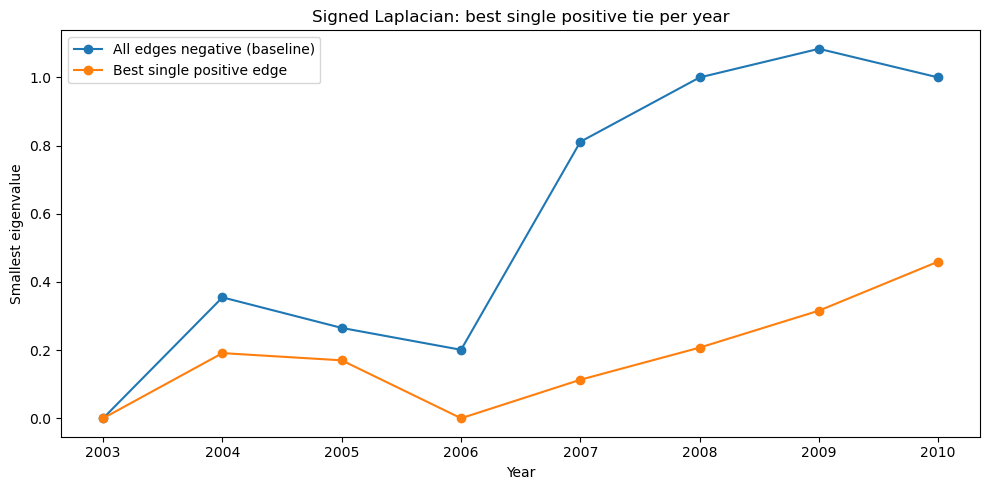

2003: best positive tie = (Sinaloa, Tijuana) | lambda_base=0.000000 -> lambda_best=0.000000 | decrease=0.000000
2004: best positive tie = (Sinaloa, Otros) | lambda_base=0.354722 -> lambda_best=0.191136 | decrease=0.163586
2005: best positive tie = (Beltran_Leyva, Sinaloa) | lambda_base=0.265030 -> lambda_best=0.169915 | decrease=0.095115
2006: best positive tie = (Golfo, Zetas) | lambda_base=0.200844 -> lambda_best=0.000000 | decrease=0.200844
2007: best positive tie = (Golfo, Zetas) | lambda_base=0.811243 -> lambda_best=0.112972 | decrease=0.698271
2008: best positive tie = (Golfo, Zetas) | lambda_base=1.000000 -> lambda_best=0.207245 | decrease=0.792755
2009: best positive tie = (Familia, Zetas) | lambda_base=1.084021 -> lambda_best=0.315724 | decrease=0.768297
2010: best positive tie = (Golfo, Zetas) | lambda_base=1.000000 -> lambda_best=0.459671 | decrease=0.540329


In [19]:
import networkx as nx
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

FAMILIES = [
    "Beltran_Leyva", "Familia", "Golfo", "Juarez",
    "Sinaloa", "Tijuana", "Zetas", "Otros"
]

def _smallest_eigpair_signed_laplacian_from_A(A, degrees, use_sparse=True):
    """
    A: csr signed adjacency (symmetric)
    degrees: 1D array with abs-degree per node (constant under sign flips here)
    """
    D = sp.diags(degrees)
    L = D - A

    if use_sparse:
        # Smallest algebraic eigenvalue
        vals, vecs = spla.eigsh(L, k=1, which="SM")
        return float(vals[0]), vecs[:, 0]
    else:
        # Dense fallback (fine for n<=8)
        Ld = L.toarray()
        vals, vecs = np.linalg.eigh(Ld)
        return float(vals[0]), vecs[:, 0]

def best_single_positive_edge_for_year(G, families=FAMILIES, use_sparse=True):
    """
    Treat ALL existing edges among `families` as negative (-1),
    then flip exactly ONE existing edge to positive (+1).
    Return the edge that yields the biggest decrease in lambda_min.
    """
    # Induce subgraph on the family nodes (keep only those present in G)
    present = [n for n in families if n in G]
    if len(present) == 0:
        return {
            "lambda_all_negative": np.nan,
            "lambda_best": np.nan,
            "delta": np.nan,
            "best_edge": None,
            "n_nodes": 0,
            "n_edges": 0,
            "nodes_used": []
        }

    H = G.subgraph(present).copy()
    n = H.number_of_nodes()
    m = H.number_of_edges()

    if n == 0 or m == 0:
        return {
            "lambda_all_negative": np.nan,
            "lambda_best": np.nan,
            "delta": np.nan,
            "best_edge": None,
            "n_nodes": n,
            "n_edges": m,
            "nodes_used": present
        }

    # Fixed ordering within the present nodes
    nodes = list(present)
    idx = {node: i for i, node in enumerate(nodes)}

    # Build base signed adjacency where every existing edge = -1
    rows, cols, data = [], [], []
    for u, v in H.edges():
        i, j = idx[u], idx[v]
        rows.extend([i, j])
        cols.extend([j, i])
        data.extend([-1.0, -1.0])

    A_base = sp.csr_matrix((data, (rows, cols)), shape=(n, n))

    # abs-degrees are constant for ±1 edges
    degrees = np.array(np.abs(A_base).sum(axis=1)).ravel()

    # Baseline: all-negative
    lam_base, _ = _smallest_eigpair_signed_laplacian_from_A(A_base, degrees, use_sparse=use_sparse)

    # Try flipping each existing edge to +1 (i.e., A_ij: -1 -> +1, delta = +2 both ways)
    best_edge = None
    best_lam = lam_base
    best_delta = 0.0  # decrease amount: lam_base - lam_candidate

    for u, v in H.edges():
        i, j = idx[u], idx[v]

        # Copy base adjacency and apply the sign flip on (i,j) and (j,i)
        A_try = A_base.copy().tolil()
        A_try[i, j] = +1.0
        A_try[j, i] = +1.0
        A_try = A_try.tocsr()

        lam_try, _ = _smallest_eigpair_signed_laplacian_from_A(A_try, degrees, use_sparse=use_sparse)

        # Clamp tiny negative numerical noise to 0
        if lam_try < 0 and abs(lam_try) < 1e-10:
            lam_try = 0.0

        delta = lam_base - lam_try  # positive means it decreased
        if delta > best_delta:
            best_delta = delta
            best_lam = lam_try
            best_edge = (u, v)

    return {
        "lambda_all_negative": float(lam_base),
        "lambda_best": float(best_lam),
        "delta": float(best_delta),
        "best_edge": best_edge,
        "n_nodes": n,
        "n_edges": m,
        "nodes_used": nodes
    }

# --------- Run over years & plot ---------

years = range(2003, 2011)

best_by_year = {}
best_lambdas = []
base_lambdas = []

for y in years:
    if y not in G_backboned:
        best_by_year[y] = None
        best_lambdas.append(np.nan)
        base_lambdas.append(np.nan)
        continue

    G = G_backboned[y]

    res = best_single_positive_edge_for_year(G, families=FAMILIES, use_sparse=True)
    best_by_year[y] = res

    base_lambdas.append(res["lambda_all_negative"])
    best_lambdas.append(res["lambda_best"])

# Plot: baseline vs best single-positive edge
plt.figure(figsize=(10, 5))
plt.plot(list(years), base_lambdas, marker="o", label="All edges negative (baseline)")
plt.plot(list(years), best_lambdas, marker="o", label="Best single positive edge")
plt.xlabel("Year")
plt.ylabel("Smallest eigenvalue")
plt.title("Signed Laplacian: best single positive tie per year")
plt.xticks(list(years))
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

# Print results per year
for y in years:
    res = best_by_year.get(y)
    if not res or res["best_edge"] is None:
        print(f"{y}: best_edge=None | lambda_base={res['lambda_all_negative'] if res else np.nan} | "
              f"lambda_best={res['lambda_best'] if res else np.nan} | delta={res['delta'] if res else np.nan}")
    else:
        u, v = res["best_edge"]
        print(f"{y}: best positive tie = ({u}, {v}) | "
              f"lambda_base={res['lambda_all_negative']:.6f} -> lambda_best={res['lambda_best']:.6f} | "
              f"decrease={res['delta']:.6f}")


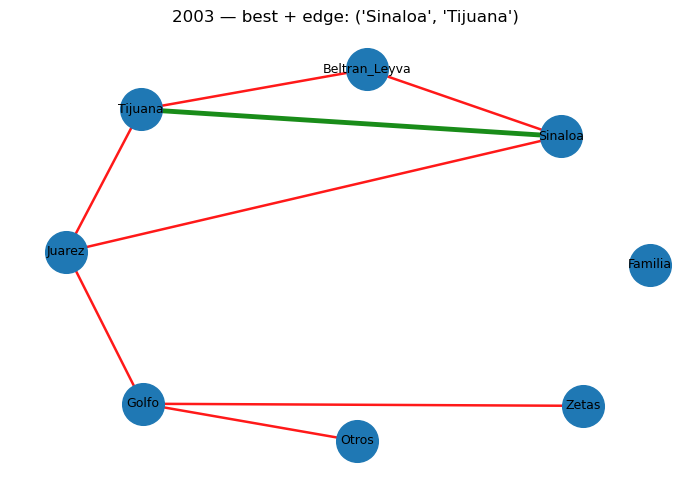

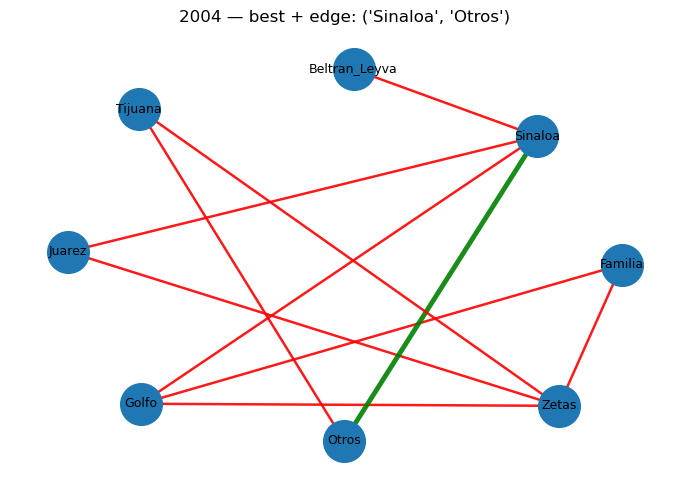

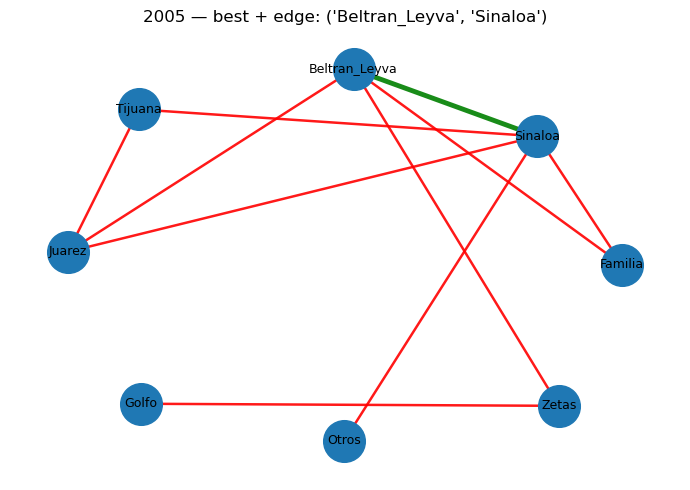

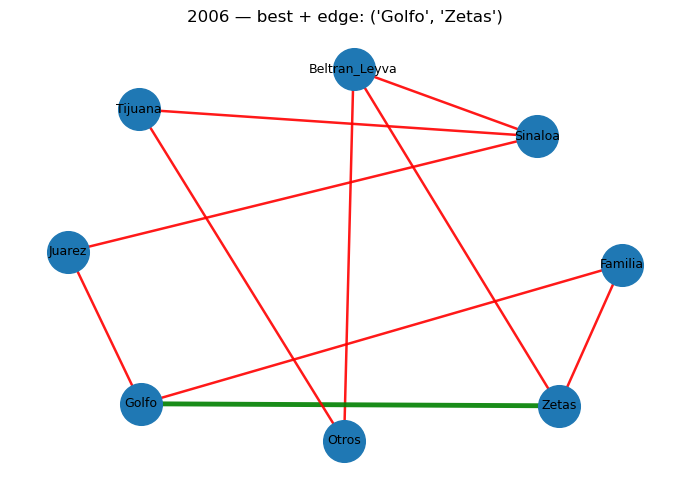

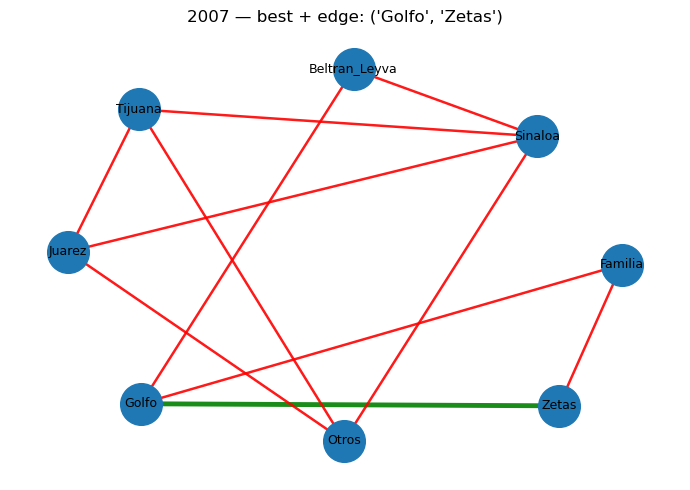

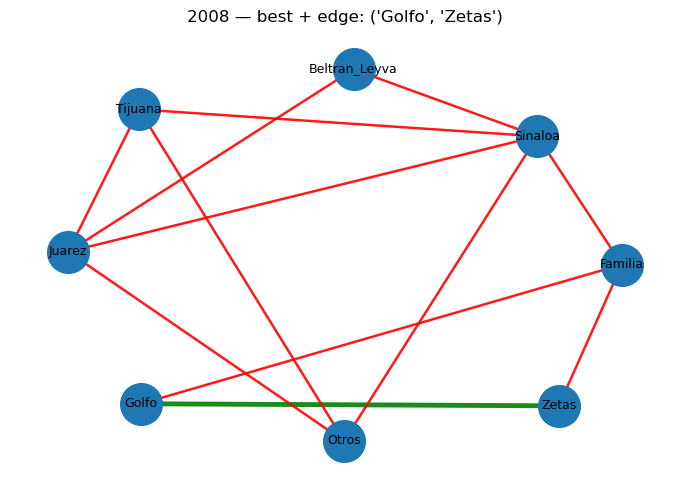

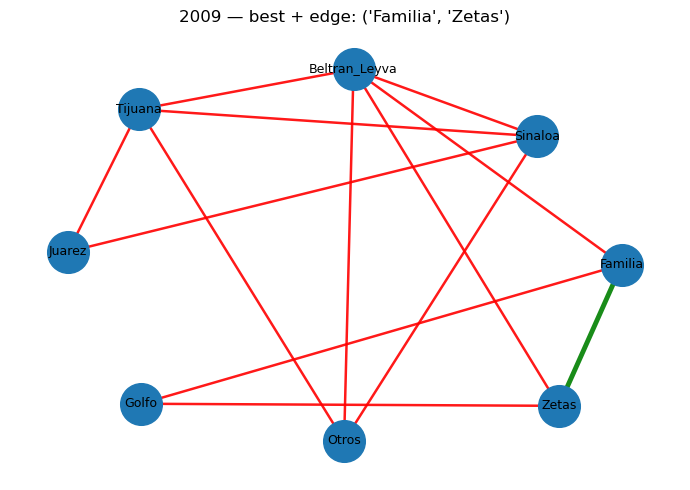

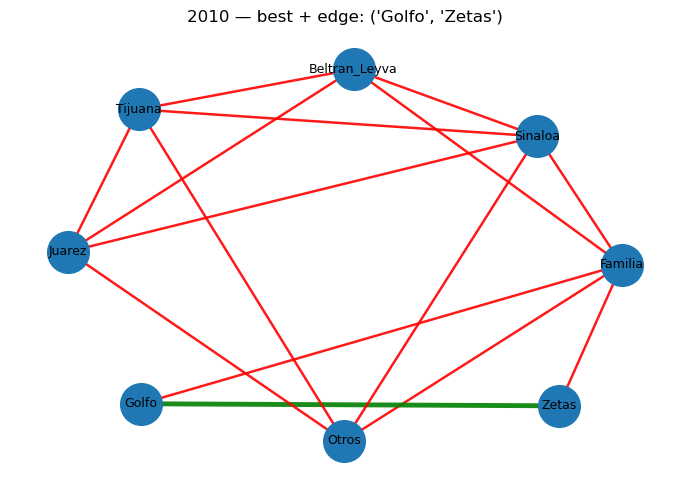

In [20]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

FAMILIES = [
    "Beltran_Leyva", "Familia", "Golfo", "Juarez",
    "Sinaloa", "Tijuana", "Zetas", "Otros"
]

def visualize_best_positive_edge_per_year(G_backboned, best_by_year, years, families=FAMILIES):
    # Use a stable node set for layout (all families), but only draw nodes present each year
    layout_graph = nx.Graph()
    layout_graph.add_nodes_from(families)

    # Fixed layout for comparability across years
    pos = nx.spring_layout(layout_graph, seed=42)

    for y in years:
        if y not in G_backboned or best_by_year.get(y) is None:
            print(f"{y}: skipping (missing year)")
            continue

        G = G_backboned[y]
        present = [n for n in families if n in G]
        H = G.subgraph(present).copy()

        if H.number_of_nodes() == 0:
            print(f"{y}: skipping (no nodes)")
            continue

        res = best_by_year[y]
        best_edge = res.get("best_edge", None)

        plt.figure(figsize=(7, 5))
        plt.title(f"{y} — best + edge: {best_edge}")

        # Draw nodes
        nx.draw_networkx_nodes(H, pos, nodelist=present, node_size=900)

        # Labels
        nx.draw_networkx_labels(H, pos, font_size=9)

        # Prepare edge color list
        edges = list(H.edges())
        edge_colors = []
        edge_widths = []

        for (u, v) in edges:
            # Treat edges as undirected: match either orientation
            if best_edge is not None and ((u, v) == best_edge or (v, u) == best_edge):
                edge_colors.append("green")
                edge_widths.append(3.5)
            else:
                edge_colors.append("red")
                edge_widths.append(1.8)

        # Draw edges
        nx.draw_networkx_edges(
            H, pos,
            edgelist=edges,
            edge_color=edge_colors,
            width=edge_widths,
            alpha=0.9
        )

        plt.axis("off")
        plt.tight_layout()
        plt.show()

# ---- run ----
years = range(2003, 2011)
visualize_best_positive_edge_per_year(G_backboned, best_by_year, years)
